# Sentimental analysis 
Lucas Caceres, Yasamin Esmaeili,Shiying Li, David Ren

In [77]:
#Do once at start

#!pip install numpy
#!pip install pandas
#!pip install sentence-transformers torch tf-kera
#!pip uninstall -y torch torchvision torchaudio
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

#!pip install "transformers==4.46.2" "sentence-transformers==3.0.1"
#!sudo chown -R $USER ~/.cache/huggingface
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')



In [78]:
#Source "kashishparmar02/social-media-sentiments-analysis-dataset"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity


In [79]:
#Setup cell - Run this first
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Now import from src
from src import load_data, clean_data, map_sentiments

print("✓ Setup complete!")
df2 = load_data('../Data/sentimentdataset.csv')
df = clean_data(df2)

✓ Setup complete!
Dataset loaded successfully with shape: (732, 15)
Dropped 2 unnamed columns: ['Unnamed: 0.1', 'Unnamed: 0']
Starting data cleaning pipeline...
Cleaned 'Platform' column - unique values: 3
Cleaned 'Sentiment' column - unique values: 191
Cleaned 'Country' column - unique values: 33
Found and removed 21 duplicate rows.
New shape: (711, 13)

=== Missing Values ===
Text         0
Sentiment    0
Timestamp    0
User         0
Platform     0
Hashtags     0
Retweets     0
Likes        0
Country      0
Year         0
Month        0
Day          0
Hour         0
dtype: int64

=== Duplicates ===
Found 0 duplicate rows.

=== Timestamp Validation ===
Timestamp column successfully converted to datetime.

=== Text Validation ===
Found 0 posts with no text.

=== Sentiment Mapping Results ===
Sentiment_Group
Joy              409
Neutral/Other    117
Sadness           83
Anger             59
Fear              25
Guilt             18
Name: count, dtype: int64

=== Cleaning Complete ===
F

In order to train a model off to detect the sentiment I am going to turn all properties to a string, and
treat the embeedings as one large word

In [80]:
#Data categories
#types = ['Text','Sentiment','Timestamp','User','Platform','Hashtags','Retweets','Likes','Country','Year','Month','Day','Hour']
types = ['Text', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes','Country', 'Year', 'Month', 'Day', 'Hour']
#types = ['Text']

def create_embedding(row_pos, types, df):
    word = []
    for cat in types:
        # iloc[row_pos] gives the row by position
        word.append(f'{cat}: {df.iloc[row_pos][cat]}')
    return '|'.join(word)

datapoints = [create_embedding(i, types, df) for i in range(len(df))]
print(datapoints)




['Text:  Enjoying a beautiful day at the park!              |Timestamp: 2023-01-15 12:30:00|User:  User123      |Platform: Twitter|Hashtags:  #Nature #Park                            |Retweets: 15.0|Likes: 30.0|Country: USA|Year: 2023|Month: 1|Day: 15|Hour: 12', 'Text:  Traffic was terrible this morning.                 |Timestamp: 2023-01-15 08:45:00|User:  CommuterX    |Platform: Twitter|Hashtags:  #Traffic #Morning                        |Retweets: 5.0|Likes: 10.0|Country: Canada|Year: 2023|Month: 1|Day: 15|Hour: 8', 'Text:  Just finished an amazing workout! 💪               |Timestamp: 2023-01-15 15:45:00|User:  FitnessFan   |Platform: Instagram|Hashtags:  #Fitness #Workout                        |Retweets: 20.0|Likes: 40.0|Country: USA|Year: 2023|Month: 1|Day: 15|Hour: 15', 'Text:  Excited about the upcoming weekend getaway!        |Timestamp: 2023-01-15 18:20:00|User:  AdventureX   |Platform: Facebook|Hashtags:  #Travel #Adventure                       |Retweets: 8.0|Likes: 15.0|C

In [81]:
#The cache is so we don't have to retrain it every time we re-use it
cache_dir = os.path.join(os.getcwd(), ".cache", "huggingface")
os.environ.update({
    "HF_HOME": cache_dir,
    "TRANSFORMERS_CACHE": cache_dir,
    "HF_DATASETS_CACHE": cache_dir
})
os.makedirs(cache_dir, exist_ok=True)
print("Using local Hugging Face cache at:", cache_dir)

sent_trans_model = SentenceTransformer("all-MiniLM-L6-v2", cache_folder=cache_dir)
print('Loaded sentence-transformer into variable `sent_trans_model`.')


Using local Hugging Face cache at: /Users/lucascaceres/Documents/ProjectRene/Sentiment_Analysis_NYUDSFall2025/notebooks/.cache/huggingface
Loaded sentence-transformer into variable `sent_trans_model`.


In [82]:
#Train model
embeddings = sent_trans_model.encode(datapoints, show_progress_bar=True)

Batches: 100%|██████████| 23/23 [00:02<00:00, 10.14it/s]


In [83]:
import numpy as np
def clean(embeddings):
    embeddings = np.asarray(embeddings)
    embeddings_df = pd.DataFrame(embeddings)

    datapoints_df = pd.DataFrame({'text_combined': datapoints})

    min_len = min(len(embeddings_df), len(datapoints_df), len(df))
    embeddings_df = embeddings_df.iloc[:min_len].reset_index(drop=True)
    datapoints_df = datapoints_df.iloc[:min_len].reset_index(drop=True)
    df_trim = df.reset_index(drop=True).iloc[:min_len]
    return df_trim,datapoints_df,embeddings_df
df_trim,datapoints_df,embeddings_df = clean(embeddings)


In [84]:
from sklearn.metrics.pairwise import cosine_similarity

query = input("Enter a Query: ")
q_emb = sent_trans_model.encode([query])
#print(q_emb)
sims = cosine_similarity(q_emb, embeddings_df.values)[0]

top_k = 5
top_k_indices = sims.argsort()[-top_k:][::-1]

results_text = datapoints_df.iloc[top_k_indices].reset_index(drop=True)
results_meta = df_trim.iloc[top_k_indices].reset_index(drop=True)
results = pd.concat([results_text, results_meta], axis=1)

print('Top matches for:', query)
print(results[['text_combined','Sentiment','Hashtags','Likes','Country']].to_string(index=False))


Top matches for: israel
                                                                                                                                                                                                                                                                                                                    text_combined  Sentiment                                      Hashtags  Likes   Country
                            Text: Amazed by the architectural marvels of Petra, each stone telling tales of an ancient civilization. |Timestamp: 2023-01-28 13:00:00|User:  PetraExplorer |Platform: Twitter|Hashtags:  #Amazement #AncientTales |Retweets: 30.0|Likes: 60.0|Country: Jordan|Year: 2023|Month: 1|Day: 28|Hour: 13  Amazement                     #Amazement #AncientTales    60.0    Jordan
                                       Text: Walking the Great Wall of China, each step a testament to ancient engineering marvels. |Timestamp: 2017-08-18 19:30:00|User:  GreatWallWalk

         Emotion  AverageSimilarity
4            joy           0.220959
1        sadness           0.177514
3           fear           0.136303
2          guilt           0.130111
0          anger           0.127938
5  Neutral/Other           0.044341


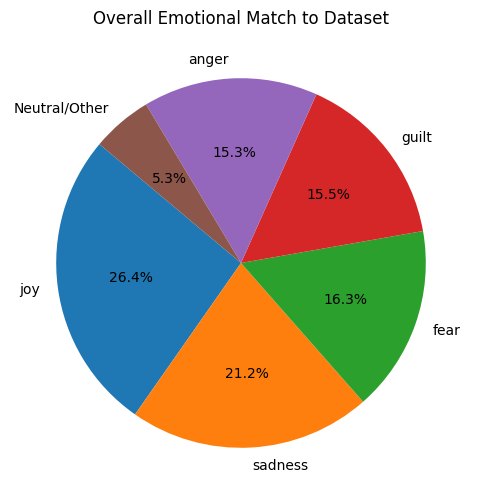

,Emotion,AverageSimilarity
4,joy,0.220959
1,sadness,0.177514
3,fear,0.136303
2,guilt,0.130111
0,anger,0.127938
5,Neutral/Other,0.044341


In [139]:
queries = ["anger", "sadness", "guilt", "fear", "joy","Neutral/Other"]

def findSimilar(queries,pie = True, newEmbedding = embeddings_df,show = True):
    query_embeddings = sent_trans_model.encode(queries)
    similarity_matrix = cosine_similarity(query_embeddings, newEmbedding.values)

    avg_scores = similarity_matrix.mean(axis=1)

    emotion_scores = pd.DataFrame({
        "Emotion": queries,
        "AverageSimilarity": avg_scores
    }).sort_values(by="AverageSimilarity", ascending=False)

    print(emotion_scores)

    plt.figure(figsize=(6,6))
    if show:
        if(pie):
            plt.pie(
                emotion_scores["AverageSimilarity"],
                labels=emotion_scores["Emotion"],
                autopct="%1.1f%%",
                startangle=140
            )
        else:
            bars = plt.bar(emotion_scores["Emotion"], emotion_scores["AverageSimilarity"], color='skyblue')
            plt.xticks(rotation=45, ha='right')
            plt.title("Overall Emotional Match to Dataset")
            plt.xlabel("Emotion", fontsize=12)
            plt.ylabel("Average Similarity", fontsize=12)

            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')
        plt.title("Overall Emotional Match to Dataset")
        plt.show()
    return emotion_scores
findSimilar(queries)

['Positive' 'Negative' 'Neutral' 'Anger' 'Fear' 'Sadness' 'Disgust'
 'Happiness' 'Joy' 'Love' 'Amusement' 'Enjoyment' 'Admiration' 'Affection'
 'Awe' 'Disappointed' 'Surprise' 'Acceptance' 'Adoration' 'Anticipation'
 'Bitter' 'Calmness' 'Confusion' 'Excitement' 'Kind' 'Pride' 'Shame'
 'Elation' 'Euphoria' 'Contentment' 'Serenity' 'Gratitude' 'Hope'
 'Empowerment' 'Compassion' 'Tenderness' 'Arousal' 'Enthusiasm'
 'Fulfillment' 'Reverence' 'Despair' 'Grief' 'Loneliness' 'Jealousy'
 'Resentment' 'Frustration' 'Boredom' 'Anxiety' 'Intimidation'
 'Helplessness' 'Envy' 'Regret' 'Curiosity' 'Indifference' 'Numbness'
 'Melancholy' 'Nostalgia' 'Ambivalence' 'Determination' 'Zest' 'Hopeful'
 'Proud' 'Grateful' 'Empathetic' 'Compassionate' 'Playful' 'Free-spirited'
 'Inspired' 'Confident' 'Bitterness' 'Yearning' 'Fearful' 'Apprehensive'
 'Overwhelmed' 'Jealous' 'Devastated' 'Frustrated' 'Envious' 'Dismissive'
 'Thrill' 'Bittersweet' 'Overjoyed' 'Inspiration' 'Motivation'
 'Contemplation' 'JoyfulR

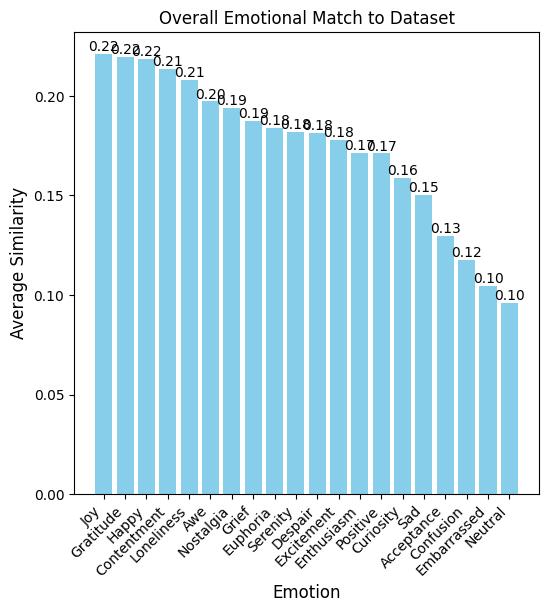

,Emotion,AverageSimilarity
1,Joy,0.220959
5,Gratitude,0.219475
8,Happy,0.218425
4,Contentment,0.213602
17,Loneliness,0.207977
12,Awe,0.197241
10,Nostalgia,0.193908
11,Grief,0.187286
19,Euphoria,0.183771
7,Serenity,0.181793


In [91]:
print(df['Sentiment'].unique())

Sentiment_counts = df['Sentiment'].value_counts()
n = 20
sentimentAndCount = Sentiment_counts[:n]
queries2 = list(sentimentAndCount.keys())
print(queries2)
findSimilar(queries2,False)

--- Processing Facebook (Total Posts: 223) ---


Batches: 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


         Emotion  AverageSimilarity
4            joy           0.225655
3           fear           0.196101
1        sadness           0.191063
2          guilt           0.187396
0          anger           0.178282
5  Neutral/Other           0.072227
--- Processing Instagram (Total Posts: 252) ---


Batches: 100%|██████████| 8/8 [00:00<00:00, 40.19it/s]


         Emotion  AverageSimilarity
4            joy           0.228486
3           fear           0.202677
2          guilt           0.190820
1        sadness           0.183022
0          anger           0.172981
5  Neutral/Other           0.072392
--- Processing Twitter (Total Posts: 236) ---


Batches: 100%|██████████| 8/8 [00:00<00:00, 44.52it/s]


         Emotion  AverageSimilarity
4            joy           0.206796
3           fear           0.202508
2          guilt           0.184813
1        sadness           0.183782
0          anger           0.171098
5  Neutral/Other           0.070022


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

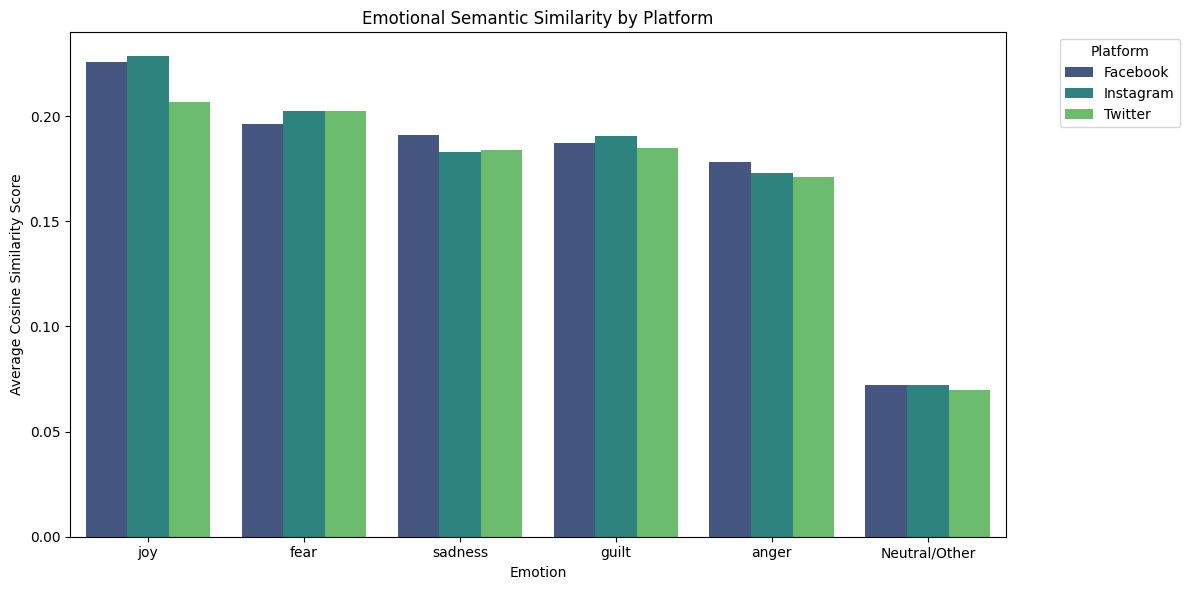

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_platform_scores = []

for platform, group_df in partitions.items():
    print(f"--- Processing {platform} (Total Posts: {len(group_df)}) ---")
    
    country_datapoints = group_df['Text'].tolist() 
    embeddings = model.encode(country_datapoints, show_progress_bar=True)
    
    _, _, newEmbeddingDF = clean(embeddings)
    queries = ["anger", "sadness", "guilt", "fear", "joy", "Neutral/Other"]
    emotion_scores = findSimilar(queries, True, newEmbeddingDF, show=False)
    
    emotion_scores['Platform'] = platform
    all_platform_scores.append(emotion_scores)

final_comparison_df = pd.concat(all_platform_scores, ignore_index=True)
plt.figure(figsize=(12, 6))

sns.barplot(
    data=final_comparison_df, 
    x='Emotion', 
    y='AverageSimilarity', 
    hue='Platform',
    palette='viridis' 
)

plt.title("Emotional Semantic Similarity by Platform")
plt.ylabel("Average Cosine Similarity Score")
plt.xlabel("Emotion")
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()